In [10]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

import explore

plt.rcParams['figure.figsize'] = (4, 2)

In [2]:
# Acquire Titanic Data from MySQL

In [3]:
import env

def get_connection(db, user=env.user, host=env.host, password=env.password):
    return f'mysql+pymysql://{user}:{password}@{host}/{db}'

def get_titanic():
    my_query="SELECT * FROM passengers"
    df = pd.read_sql(my_query, get_connection('titanic_db'))
    return df

In [4]:
df = get_titanic()
df.head(2)

,passenger_id,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,deck,embark_town,alone
0,0,0,3,male,22.0,1,0,7.2500,S,Third,None,Southampton,0
1,1,1,1,female,38.0,1,0,71.2833,C,First,C,Cherbourg,0


In [5]:
# drop rows where age or embarked is null, drop column 'deck', drop passenger_id
def prep_titanic(df):
    '''
    take in titanc dataframe, remove all rows where age or embarked is null, 
    get dummy variables for sex and embark_town, 
    and drop sex, deck, passenger_id, class, and embark_town. 
    '''
    df = (
        df[(df.age.notna()) & (df.embarked.notna())].
        drop(columns=['deck', 'passenger_id', 'class']))
    dummy_df = (
        pd.get_dummies(df[['sex', 'embark_town']], prefix=['sex', 'embark']))
    df = (
        pd.concat([df, dummy_df.drop(columns=['sex_male'])], axis=1).
        drop(columns=['sex', 'embark_town']))
    return df

In [6]:
df = prep_titanic(df)
df.head(2)

,survived,pclass,age,sibsp,parch,fare,embarked,alone,sex_female,embark_Cherbourg,embark_Queenstown,embark_Southampton
0,0,3,22.0,1,0,7.2500,S,0,0,0,0,1
1,1,1,38.0,1,0,71.2833,C,0,1,1,0,0


In [7]:
def train_validate_test_split(df, target, seed=123):
    '''
    This function takes in a dataframe, the name of the target variable
    (for stratification purposes), and an integer for a setting a seed
    and splits the data into train, validate and test. 
    Test is 20% of the original dataset, validate is .30*.80= 24% of the 
    original dataset, and train is .70*.80= 56% of the original dataset. 
    The function returns, in this order, train, validate and test dataframes. 
    '''
    train_validate, test = train_test_split(df, test_size=0.2, 
                                            random_state=seed, 
                                            stratify=df[target])
    train, validate = train_test_split(train_validate, test_size=0.3, 
                                       random_state=seed,
                                       stratify=train_validate[target])
    return train, validate, test

In [8]:
train, validate, test = train_validate_test_split(df, target='survived')
train.head(2)
# What are our observations?
# A person on the titanic
# In tidy data, every row is an observation

,survived,pclass,age,sibsp,parch,fare,embarked,alone,sex_female,embark_Cherbourg,embark_Queenstown,embark_Southampton
450,0,2,36.0,1,2,27.75,S,0,0,0,0,1
543,1,2,32.0,1,0,26.00,S,0,0,0,0,1


In [9]:
print(train.shape, validate.shape, test.shape)

(398, 12) (171, 12) (143, 12)


# Univariate Stats
### Always explore your train data

In [12]:
cat_vars = ['survived', 'pclass', 'sibsp', 'parch', 'embarked', 'alone', 'sex_female']
quant_vars = ['age', 'fare']

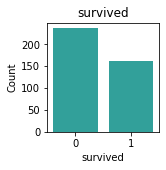

   survived  Count  Percent
0         0    237    59.55
1         1    161    40.45
_________________________________________________________________


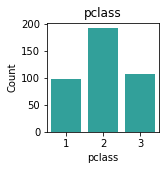

   pclass  Count  Percent
3       2    192    48.24
1       3    108    27.14
2       1     98    24.62
_________________________________________________________________


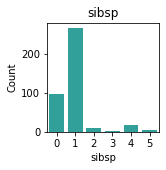

   sibsp  Count  Percent
0      1    265    66.58
1      0     98    24.62
2      4     18     4.52
4      2     10     2.51
3      5      5     1.26
5      3      2     0.50
_________________________________________________________________


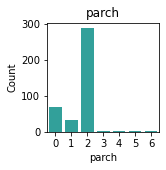

   parch  Count  Percent
0      2    288    72.36
1      0     69    17.34
2      1     34     8.54
5      3      3     0.75
3      6      2     0.50
4      4      1     0.25
6      5      1     0.25
_________________________________________________________________


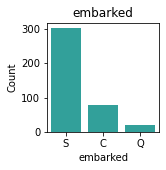

  embarked  Count  Percent
S        S    302    75.88
C        C     77    19.35
Q        Q     19     4.77
_________________________________________________________________


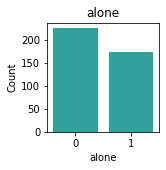

   alone  Count  Percent
1      0    225    56.53
0      1    173    43.47
_________________________________________________________________


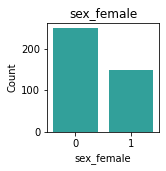

   sex_female  Count  Percent
0           0    249    62.56
1           1    149    37.44
_________________________________________________________________


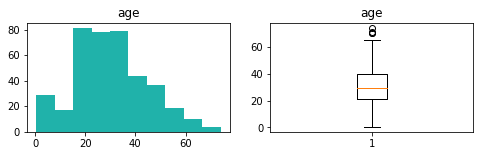

count    398.000000
mean      30.222161
std       14.595995
min        0.420000
25%       21.000000
50%       29.000000
75%       40.000000
max       74.000000
Name: age, dtype: float64


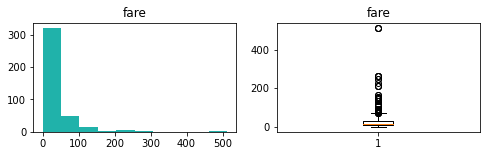

count    398.000000
mean      37.093718
std       61.282772
min        0.000000
25%        8.050000
50%       15.850000
75%       32.875000
max      512.329200
Name: fare, dtype: float64


In [13]:
explore.explore_univariate(train, cat_vars, quant_vars)

### Takeaways & Actions

- 60% did NOT survive. This will be my baseline prediction to test the usefulness of features on later when we get to modeling.

- Survived can be treated as either a categorical variable or a number. We can view survived via color on a chart, as categories on the x-axis on a bar chart, or as a proportion between 0 and 1 on the y-axis when viewing another categorical variable to compare "survival rate".

- We can compare proportions of those who survived and those who didn't with another categorical variable. For example, we can test is female passengers were more or less likely to survive than male passengers using a chi-square test.

- We can compare the mean of continuous variables between those who survived to those who did not survive using a test such as a t-test or Mann-Whitney test (the non-parametric version of the t-test). Such as, is there a difference in the average fare paid for those who survived vs. those who did not survive?

- what else?

In [14]:
# Bivariate Stats

In [15]:
print(cat_vars)
print(quant_vars)

['survived', 'pclass', 'sibsp', 'parch', 'embarked', 'alone', 'sex_female']
['age', 'fare']


In [16]:
cat_vars = cat_vars[1:]

pclass 
_____________________

        chi2       p-value  degrees of freedom
0  65.198138  6.956717e-15                   2

observed:
 survived    0    1  All
pclass                 
1          36   72  108
2          49   49   98
3         152   40  192
All       237  161  398

expected:
             0          1
0   64.311558  43.688442
1   58.356784  39.643216
2  114.331658  77.668342


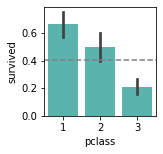


_____________________

sibsp 
_____________________

        chi2   p-value  degrees of freedom
0  10.869694  0.054026                   5

observed:
 survived    0    1  All
sibsp                  
0         168   97  265
1          47   51   98
2           9    9   18
3           3    2    5
4           8    2   10
5           2    0    2
All       237  161  398

expected:
             0           1
0  157.801508  107.198492
1   58.356784   39.643216
2   10.718593    7.281407
3    2.977387    2.022613
4    5.954774    4.045226
5    1.190955    0.809045


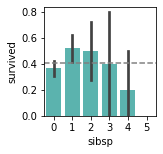


_____________________

parch 
_____________________

       chi2   p-value  degrees of freedom
0  23.68465  0.000597                   6

observed:
 survived    0    1  All
parch                  
0         191   97  288
1          27   42   69
2          14   20   34
3           1    1    2
4           1    0    1
5           2    1    3
6           1    0    1
All       237  161  398

expected:
             0           1
0  171.497487  116.502513
1   41.087940   27.912060
2   20.246231   13.753769
3    1.190955    0.809045
4    0.595477    0.404523
5    1.786432    1.213568
6    0.595477    0.404523


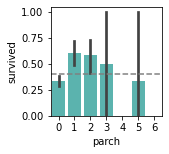


_____________________

embarked 
_____________________

        chi2   p-value  degrees of freedom
0  22.908527  0.000011                   2

observed:
 survived    0    1  All
embarked               
C          28   49   77
Q          15    4   19
S         194  108  302
All       237  161  398

expected:
             0           1
0   45.851759   31.148241
1   11.314070    7.685930
2  179.834171  122.165829


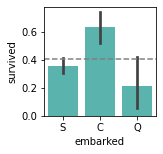


_____________________

alone 
_____________________

        chi2   p-value  degrees of freedom
0  19.653212  0.000009                   1

observed:
 survived    0    1  All
alone                  
0          81   92  173
1         156   69  225
All       237  161  398

expected:
             0          1
0  103.017588  69.982412
1  133.982412  91.017588


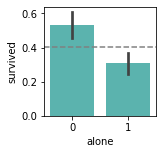


_____________________

sex_female 
_____________________

         chi2       p-value  degrees of freedom
0  116.861777  3.077879e-27                   1

observed:
 survived      0    1  All
sex_female               
0           200   49  249
1            37  112  149
All         237  161  398

expected:
             0           1
0  148.273869  100.726131
1   88.726131   60.273869


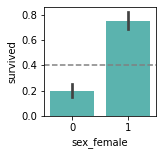


_____________________

age 
____________________



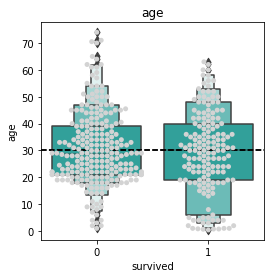

          count       mean        std   min   25%   50%   75%   max
survived                                                           
0         237.0  30.713080  13.953310  1.00  21.0  28.5  39.0  74.0
1         161.0  29.499503  15.509858  0.42  19.0  30.0  40.0  63.0 


Mann-Whitney Test:
 MannwhitneyuResult(statistic=19236.5, pvalue=0.8887609800457109)

____________________

fare 
____________________



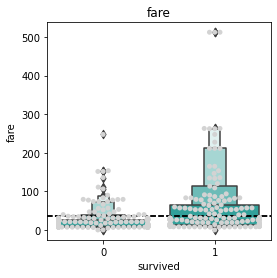

          count       mean        std  min      25%      50%      75%  \
survived                                                                
0         237.0  22.587446  29.093768  0.0   7.8958  10.5167  26.0000   
1         161.0  58.447673  85.436964  0.0  13.0000  26.5500  63.3583   

               max  
survived            
0         247.5208  
1         512.3292   


Mann-Whitney Test:
 MannwhitneyuResult(statistic=10688.5, pvalue=9.330237689194033e-14)

____________________



In [17]:
explore.explore_bivariate(train, 'survived', cat_vars, quant_vars)

### Takeaways

- bin parch: 0, 1, 2+

- bin sibsp: 0, 1, 2+

- use parch and sibsp in model as opposed to 'alone', but keep alone for exploration and testing purposes as it's easier to view a single variable than 2 variables.

- children appear more likely to survive. A new feature of is_child, instead of the age might be useful.

- What else do you notice?

In [18]:
# add this to prep, but temporarily I will add them to train. 

train['parch'] = pd.cut(train.parch, bins = [0, 1, 2, 6], right=False, labels=[0, 1, 2])
train['sibsp'] = pd.cut(train.sibsp, bins = [0, 1, 2, 5], right=False, labels=[0, 1, 2])
train['is_adult'] = pd.cut(train.age, bins = [0, 15, 74], right=False, labels=[0, 1])

In [19]:
cat_vars = ['pclass', 'sibsp', 'parch', 'embarked', 'sex_female', 'is_adult']

# Multivariate Stats & Analysis

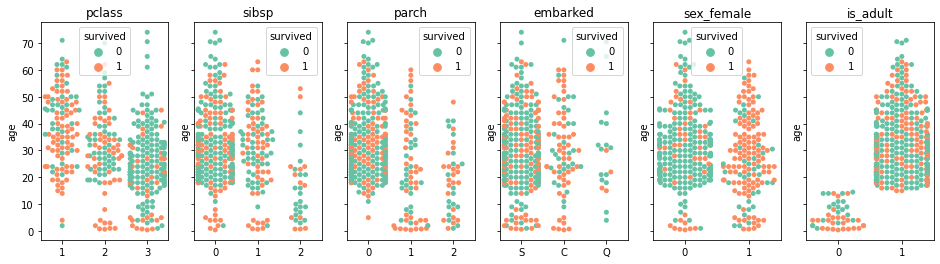

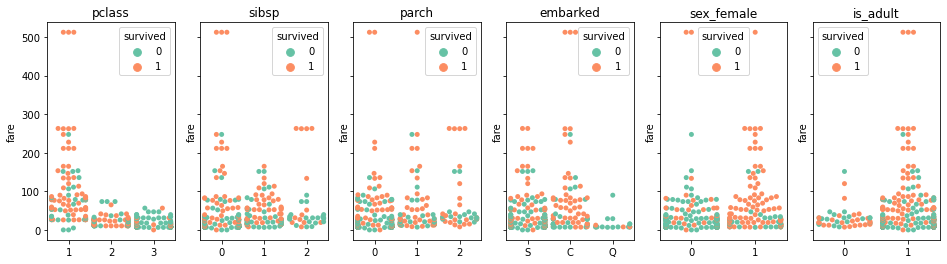

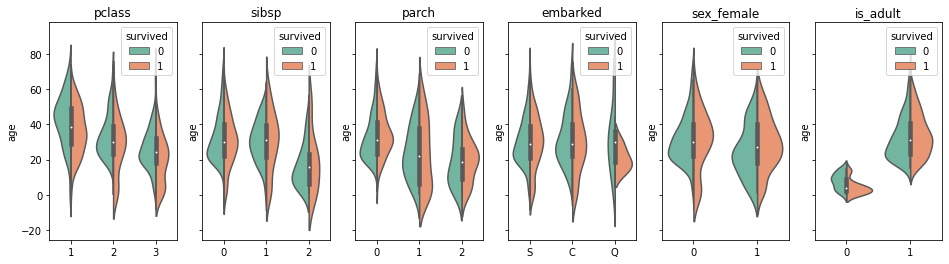

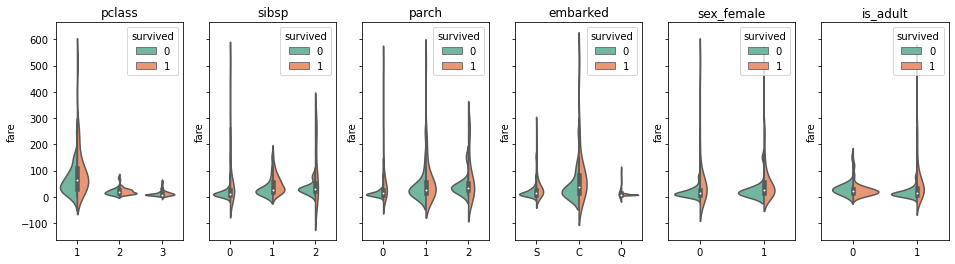

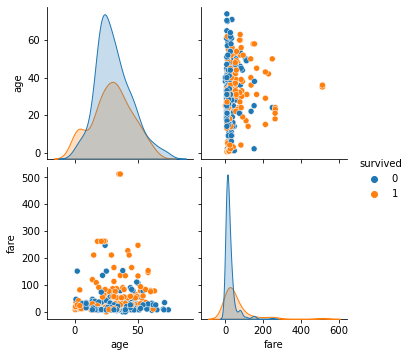

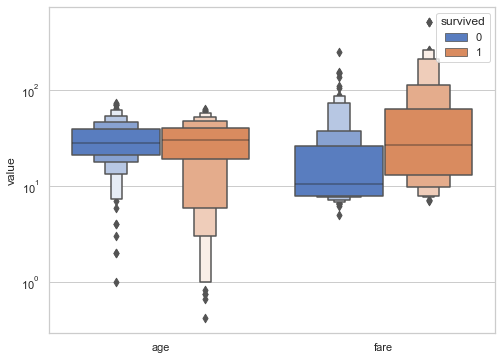

In [21]:
target = 'survived'

explore.explore_multivariate(train, target, cat_vars, quant_vars)

# Get Creative
## Ask additional, more specific and targeted questions of the data, such as how subgroups compare to each-other and to the overall population. We then answer these questions using visualizations and/or hypothesis testing.

- Are male traveling alone less likely to survive than males traveling with others?
- Of the females traveling alone, is there a difference in age of who survived and who didn't?
- Of the females traveling alone, was passenger class the difference in who survived and who didnt?
- Of passengers in 3rd class, who survived?
- 3rd class passengers traveling alone...are there any who survived?
### 1. Are males traveling alone less likely to survive than males traveling with others?

### Look at the data.
### Plot it.
### Test it.

alone 
_____________________

       chi2  p-value  degrees of freedom
0  3.133266  0.07671                   1

observed:
 survived    0   1  All
alone                 
0          57  21   78
1         143  28  171
All       200  49  249

expected:
             0          1
0   62.650602  15.349398
1  137.349398  33.650602


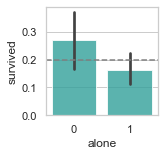


_____________________



In [22]:
male_subset = train[train.sex_female==0]

explore.explore_bivariate_categorical(male_subset, 'survived', 'alone')

### Takeaway

There is somewhat of a relationship, but at the 90% confidence level, instead of 95%, with a p-value of .077. So while it is not super strong, it does appear that males who were not traveling alone were more likely to survive. My guess is that is because kids are more likely to survive, and adults are more likely to travel alone than kids.

### 2. Of the females traveling alone, is there a difference in age of who survived and who didn't?

age 
____________________



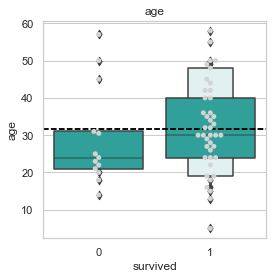

          count       mean        std   min   25%   50%   75%   max
survived                                                           
0          13.0  29.269231  13.239171  14.0  21.0  24.0  31.0  57.0
1          41.0  32.243902  11.920110   5.0  24.0  30.0  40.0  58.0 


Mann-Whitney Test:
 MannwhitneyuResult(statistic=211.0, pvalue=0.2654028056630081)

____________________



In [25]:
solo_females_subset = train[(train.sex_female==1) & (train.alone==1)]

explore.explore_bivariate_quant(solo_females_subset, 'survived', 'age')

### Takeaway
There is not a significant difference in the age of the females traveling alone who survived vs. those who did not.

### 3. Of the females traveling alone, was passenger class the difference in who survived and who didnt?

pclass 
_____________________

        chi2   p-value  degrees of freedom
0  18.344925  0.000104                   2

observed:
 survived   0   1  All
pclass               
1          1  17   18
2          1  16   17
3         11   8   19
All       13  41   54

expected:
           0          1
0  4.333333  13.666667
1  4.092593  12.907407
2  4.574074  14.425926


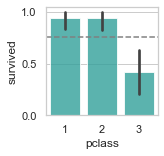


_____________________



In [26]:

explore.explore_bivariate_categorical(solo_females_subset, 'survived', 'pclass')

### Takeaway

If you were a female traveling alone and you survived, you were likely traveling in first or second class!

### 4. Of passengers in 3rd class, who survived?

pclass 
_____________________

   chi2  p-value  degrees of freedom
0   0.0      1.0                   0

observed:
 survived    0   1  All
pclass                
3         152  40  192
All       152  40  192

expected:
        0     1
0  152.0  40.0


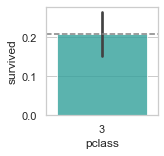


_____________________

sibsp 
_____________________

       chi2   p-value  degrees of freedom
0  0.187889  0.910333                   2

observed:
 survived    0   1  All
sibsp                 
0         110  28  138
1          24   7   31
2          16   5   21
All       150  40  190

expected:
             0          1
0  108.947368  29.052632
1   24.473684   6.526316
2   16.578947   4.421053


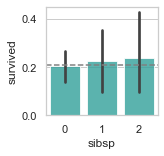


_____________________

parch 
_____________________

        chi2   p-value  degrees of freedom
0  10.000027  0.006738                   2

observed:
 survived    0   1  All
parch                 
0         119  22  141
1          18  12   30
2          14   6   20
All       151  40  191

expected:
             0          1
0  111.471204  29.528796
1   23.717277   6.282723
2   15.811518   4.188482


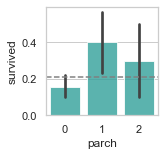


_____________________

embarked 
_____________________

       chi2   p-value  degrees of freedom
0  8.124372  0.017211                   2

observed:
 survived    0   1  All
embarked              
C          13  10   23
Q          14   3   17
S         125  27  152
All       152  40  192

expected:
             0          1
0   18.208333   4.791667
1   13.458333   3.541667
2  120.333333  31.666667


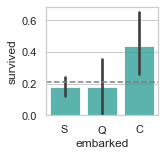


_____________________

sex_female 
_____________________

        chi2       p-value  degrees of freedom
0  28.084358  1.161408e-07                   1

observed:
 survived      0   1  All
sex_female              
0           121  14  135
1            31  26   57
All         152  40  192

expected:
          0       1
0  106.875  28.125
1   45.125  11.875


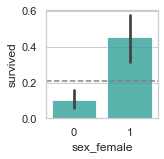


_____________________

is_adult 
_____________________

       chi2   p-value  degrees of freedom
0  8.394989  0.003763                   1

observed:
 survived    0   1  All
is_adult              
0          18  13   31
1         133  27  160
All       151  40  191

expected:
             0          1
0   24.507853   6.492147
1  126.492147  33.507853


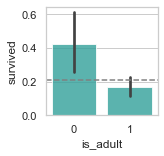


_____________________

age 
____________________



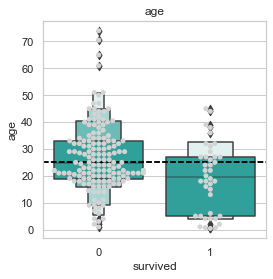

          count       mean        std   min   25%    50%   75%   max
survived                                                            
0         152.0  26.851974  12.507460  1.00  19.0  24.75  33.0  74.0
1          40.0  19.223000  12.875491  0.42   5.0  19.50  27.0  45.0 


Mann-Whitney Test:
 MannwhitneyuResult(statistic=3967.5, pvalue=0.003017714462269748)

____________________

fare 
____________________



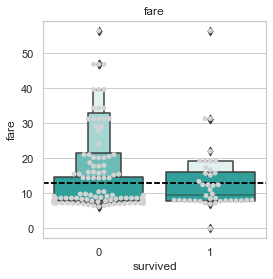

          count       mean       std     min    25%      50%       75%  \
survived                                                                 
0         152.0  12.991665  9.894843  6.2375  7.775  8.05000  14.68645   
1          40.0  13.360313  9.511468  0.0000  7.925  9.59585  16.06250   

              max  
survived           
0         56.4958  
1         56.4958   


Mann-Whitney Test:
 MannwhitneyuResult(statistic=2533.0, pvalue=0.1050112796865297)

____________________



In [27]:
third_class_subset = train[train.pclass==3]

explore.explore_bivariate(third_class_subset, 'survived', cat_vars, quant_vars)

### Takeaways

Third-class passengers more likely to survive:

embarking from Cherbourg
not traveling alone (specifically traveling with parents or children)
female
a child

### 5. 3rd class passengers traveling alone...are there any who survived?

pclass 
_____________________

   chi2  p-value  degrees of freedom
0   0.0      1.0                   0

observed:
 survived    0   1  All
pclass                
3         103  19  122
All       103  19  122

expected:
        0     1
0  103.0  19.0


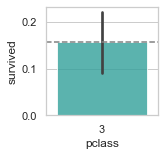


_____________________

sibsp 
_____________________

   chi2  p-value  degrees of freedom
0   0.0      1.0                   0

observed:
 survived    0   1  All
sibsp                 
0         103  19  122
All       103  19  122

expected:
        0     1
0  103.0  19.0


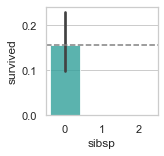


_____________________

parch 
_____________________

   chi2  p-value  degrees of freedom
0   0.0      1.0                   0

observed:
 survived    0   1  All
parch                 
0         103  19  122
All       103  19  122

expected:
        0     1
0  103.0  19.0


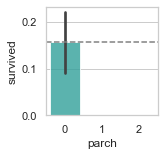


_____________________

embarked 
_____________________

       chi2  p-value  degrees of freedom
0  1.047552  0.59228                   2

observed:
 survived    0   1  All
embarked              
C           7   2    9
Q          10   3   13
S          86  14  100
All       103  19  122

expected:
            0          1
0   7.598361   1.401639
1  10.975410   2.024590
2  84.426230  15.573770


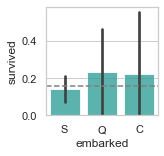


_____________________

sex_female 
_____________________

       chi2   p-value  degrees of freedom
0  9.776822  0.001767                   1

observed:
 survived      0   1  All
sex_female              
0            92  11  103
1            11   8   19
All         103  19  122

expected:
            0          1
0  86.959016  16.040984
1  16.040984   2.959016


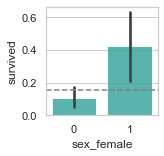


_____________________

is_adult 
_____________________

       chi2   p-value  degrees of freedom
0  1.484878  0.223013                   1

observed:
 survived    0   1  All
is_adult              
0           2   2    4
1         100  17  117
All       102  19  121

expected:
            0          1
0   3.371901   0.628099
1  98.628099  18.371901


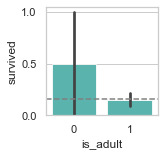


_____________________

age 
____________________



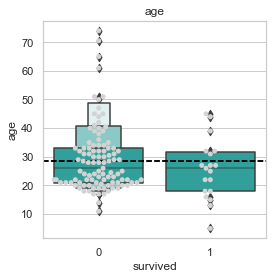

          count       mean        std   min   25%   50%   75%   max
survived                                                           
0         103.0  29.233010  11.579820  11.0  21.0  26.0  33.0  74.0
1          19.0  25.473684  10.383579   5.0  18.0  26.0  31.5  45.0 


Mann-Whitney Test:
 MannwhitneyuResult(statistic=1133.0, pvalue=0.27642486552600076)

____________________

fare 
____________________



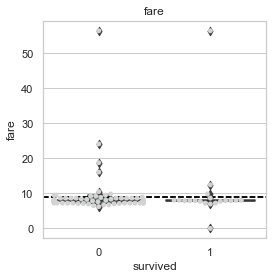

          count       mean        std     min   25%     50%      75%      max
survived                                                                     
0         103.0   8.756024   5.222737  6.2375  7.75  7.8958  8.10415  56.4958
1          19.0  10.326758  11.399911  0.0000  7.75  7.9250  8.05000  56.4958 


Mann-Whitney Test:
 MannwhitneyuResult(statistic=906.5, pvalue=0.6127291965851207)

____________________



In [29]:
solo_third_class_subset = train[(train.pclass==3) & (train.alone==1)]

explore.explore_bivariate(solo_third_class_subset, 'survived', cat_vars, quant_vars)

### Takeaways

- only 19/103 (18%) of solo, 3rd class customers survived.
- Of this subset, females were significantly more likely to survive than males.